# Import libraries

In [76]:
import shutil
import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import  mean_absolute_error
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import hog
import warnings
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint

# Import data

In [2]:
# Data cleaning
df = pd.read_csv('data.csv', usecols=[0, 1, 3, 4])
df['pathology'] = df['pathology'].apply(lambda x: tuple(x.split("|")) if "|" in x else x)

# Working dataset with a portion of the entire dataset
# dff = df.sample(2000, axis=0).reset_index(drop=True)
dff = df.sample(5000,axis=0).reset_index(drop=True)

dff_sani = df[df['pathology'] == 'No Finding'].reset_index(drop=True)
dff_malati = df[df['pathology'] != 'No Finding'].reset_index(drop=True)

In [3]:
dff_sani

,img_id,pathology,age,gender
0,00000002_000.png,No Finding,80,M
1,00000006_000.png,No Finding,81,M
2,00000007_000.png,No Finding,82,M
3,00000014_000.png,No Finding,60,F
4,00000015_000.png,No Finding,70,M
...,...,...,...,...
12783,00030800_000.png,No Finding,33,F
12784,00030802_000.png,No Finding,28,M
12785,00030803_000.png,No Finding,42,F
12786,00030804_000.png,No Finding,29,F


In [4]:
dff_malati

,img_id,pathology,age,gender
0,00000004_000.png,"(Mass, Nodule)",82,M
1,00000009_000.png,Emphysema,72,M
2,00000010_000.png,Infiltration,84,F
3,00000012_000.png,"(Effusion, Mass)",76,M
4,00000019_000.png,"(Atelectasis, Effusion, Pleural_Thickening)",66,M
...,...,...,...,...
4710,00030774_000.png,Consolidation,43,F
4711,00030780_000.png,Atelectasis,66,M
4712,00030789_000.png,Infiltration,51,F
4713,00030793_000.png,"(Mass, Nodule)",57,F


# Data exploration

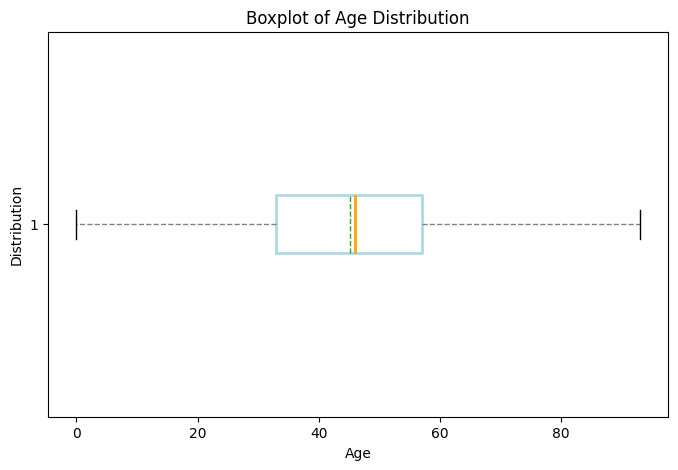

In [97]:
plt.figure(figsize=(8,5))

plt.boxplot(dff['age'], vert=False, meanline=True, showmeans=True, showfliers=True,
            boxprops=dict(color='lightblue', linewidth=2),  
            whiskerprops=dict(color='gray', linestyle='--'),  
            medianprops=dict(color='orange', linewidth=2),  
            flierprops=dict(marker='o', markersize=6, markerfacecolor='red', markeredgecolor='red'))

plt.xlabel('Age')
plt.ylabel('Distribution')
plt.title('Boxplot of Age Distribution')

plt.show()

72.04% of records do not contain pathologies


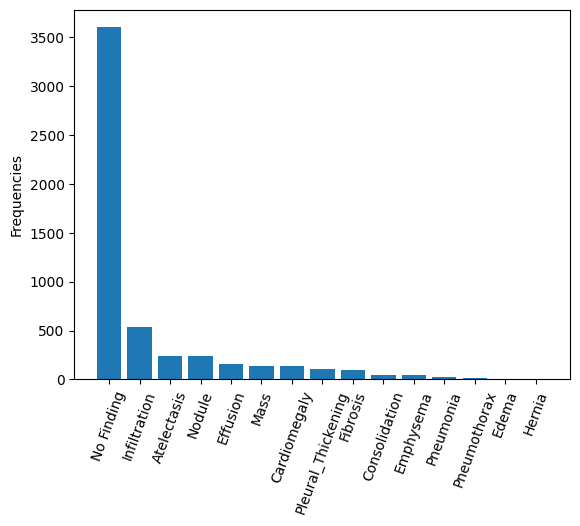

In [6]:
pathologies = {} #conteggio patologie uniche
path_count = {} #ricorrenze per numero di patologie per record (path_count[0] = numero di no finding, etc)
for p in dff['pathology']:
    
    if isinstance(p, str):
        
        if p == 'No Finding':
            if 0 not in path_count:
                path_count[0] = 1
            else:
                path_count[0] += 1
        else:
            if 1 not in path_count:
                path_count[1] = 1
            else:
                path_count[1] +=1
                    
        if p not in pathologies:
            pathologies[p] = 1
        else:
            pathologies[p] += 1
            
    elif isinstance(p, tuple):
        
        if len(p) not in path_count:
            path_count[len(p)] = 1
        else:
            path_count[len(p)] += 1
            
        for i in p:
            if i not in pathologies:
                pathologies[i] = 1
            else:
                pathologies[i] += 1

sort_pathologies = dict(sorted(pathologies.items(), key=lambda item: item[1], reverse=True))

print(f"{pathologies['No Finding'] / len(dff['pathology']) * 100:.2f}% of records do not contain pathologies")

# Plotting the occurrences of the unique pathologies
plt.bar(list(sort_pathologies.keys()), list(sort_pathologies.values()))
plt.ylabel('Frequencies')
plt.xticks(rotation=70)
plt.show()

# Features extraction

In [7]:
# Features extraction
encoded_pathologies = set()

def encode_pathology(pathology):
    if isinstance(pathology, str):
        return 0 if pathology == "No Finding" else 1
    return len(pathology)

dff['encoded_pathology'] = dff['pathology'].apply(encode_pathology)
dff['encoded_gender'] = dff['gender'].apply(lambda x: 1 if x == 'M' else 0)

dff_sani['encoded_gender'] = dff_sani['gender'].apply(lambda x: 1 if x == 'M' else 0)

dff_malati['encoded_pathology'] = dff_malati['pathology'].apply(encode_pathology)
dff_malati['encoded_gender'] = dff_malati['gender'].apply(lambda x: 1 if x == 'M' else 0)

# Image pre-processing and Feature extraction
def process_and_extract_features(row):
    image_path = os.path.join('img', row)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32) / 255.0

    features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return features

# Process and extract features for healthy subjects
image_features_sani = []
for row in tqdm(dff_sani['img_id']):
    features = process_and_extract_features(row)
    image_features_sani.append(features)

# Process and extract features for patients
image_features_malati = []
for row in tqdm(dff_malati['img_id']):
    features = process_and_extract_features(row)
    image_features_malati.append(features)

# Process and extract features for all images
image_features = []
for row in tqdm(dff['img_id']):
    features = process_and_extract_features(row)
    image_features.append(features)

image_features_sani = np.array(image_features_sani)
image_features_malati = np.array(image_features_malati)
image_features = np.array(image_features)


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:28<00:00, 23.96it/s]


In [8]:
dff_sani['encoded_pathology'] = dff_sani['pathology'].apply(encode_pathology)
dff_sani

,img_id,pathology,age,gender,encoded_gender,encoded_pathology
0,00000002_000.png,No Finding,80,M,1,0
1,00000006_000.png,No Finding,81,M,1,0
2,00000007_000.png,No Finding,82,M,1,0
3,00000014_000.png,No Finding,60,F,0,0
4,00000015_000.png,No Finding,70,M,1,0
...,...,...,...,...,...,...
12783,00030800_000.png,No Finding,33,F,0,0
12784,00030802_000.png,No Finding,28,M,1,0
12785,00030803_000.png,No Finding,42,F,0,0
12786,00030804_000.png,No Finding,29,F,0,0


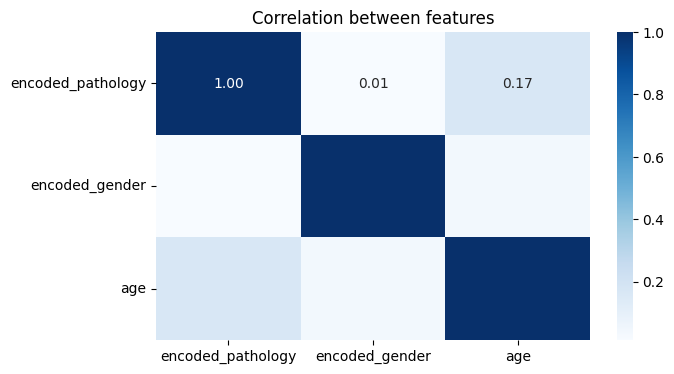

In [70]:
# Correlation between features
correlation_matrix = dff[['encoded_pathology', 'encoded_gender', 'age']].corr()

plt.figure(figsize=(7,4))  
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f") 
plt.title('Correlation between features')

plt.show()

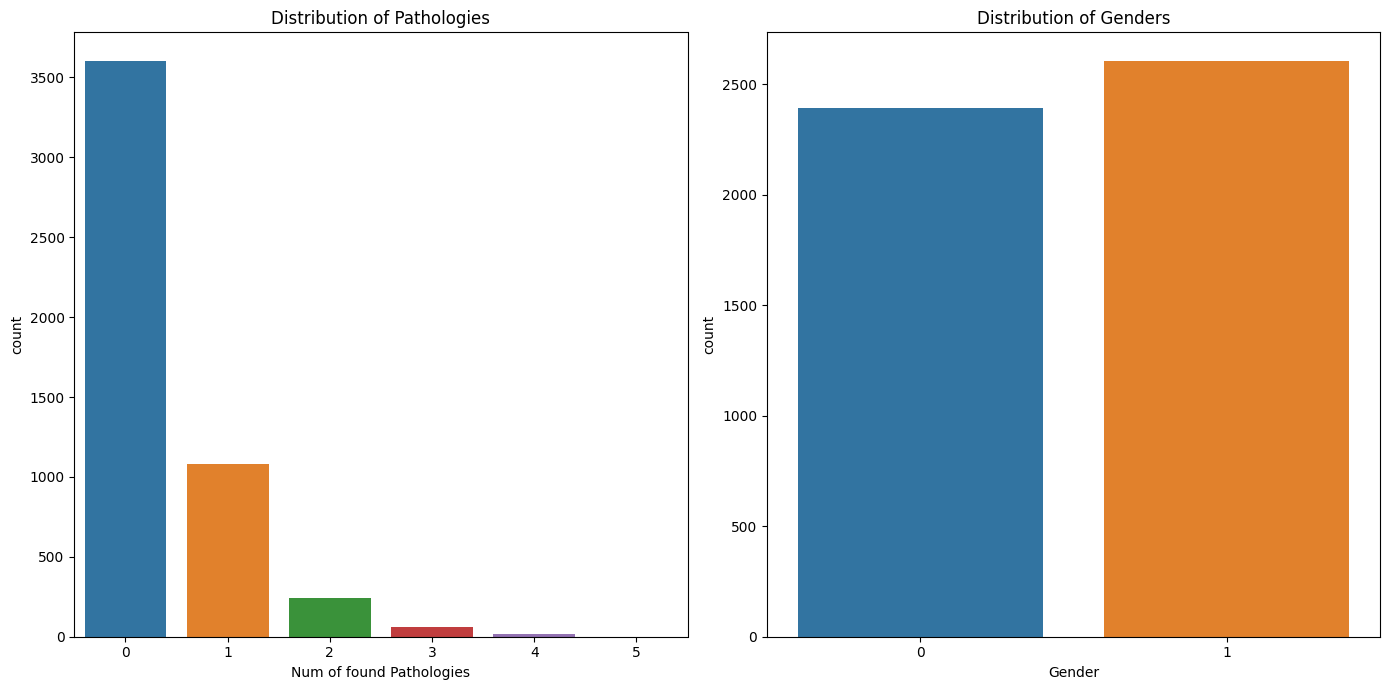

In [62]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x='encoded_pathology', data=dff)
plt.xlabel('Num of found Pathologies')
plt.title('Distribution of Pathologies')

plt.subplot(1, 2, 2)
sns.countplot(x='encoded_gender', data=dff)
plt.xlabel('Gender')
plt.title('Distribution of Genders')

plt.tight_layout()  
plt.show()

# Features combination

In [10]:
combined_sani = np.concatenate((image_features_sani, dff_sani[['encoded_pathology', 'encoded_gender']].values), axis=1)

combined_malati = np.concatenate((image_features_malati, dff_malati[['encoded_pathology', 'encoded_gender']].values), axis=1)

combined = np.concatenate((image_features, dff[['encoded_pathology', 'encoded_gender']].values), axis=1)

# GridSearch for the best parameters

In [11]:
t1 = time.time()
# Parameters for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'class_weight' : [None, 'balanced']
}

svm_model = svm.SVC()
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, scoring='neg_mean_absolute_error', cv=5)
svm_grid_search.fit(combined, dff['age'])

t2 = time.time()

print("Elapsed time:", t2-t1)
print("Best Parameters for SVM:", svm_grid_search.best_params_)
print("Best MAE Mean for SVM:", -svm_grid_search.best_score_)

C:\Users\curci\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Elapsed time: 9119.999322891235
Best Parameters for SVM: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best MAE Mean for SVM: 11.4504


In [12]:
t1 = time.time()
# Parameters for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf_model = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, scoring='neg_mean_absolute_error', cv=5)
rf_grid_search.fit(combined, dff['age'])

t2=time.time()

print("Elapsed time:", t2-t1)
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best MAE Mean for Random Forest:", -rf_grid_search.best_score_)

C:\Users\curci\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Elapsed time: 24102.234359025955
Best Parameters for Random Forest: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Best MAE Mean for Random Forest: 12.322


In [13]:
t1=time.time()
# Parameters for AdaBoost
ab_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

ab_model = AdaBoostClassifier()
ab_grid_search = GridSearchCV(ab_model, ab_param_grid, scoring='neg_mean_absolute_error', cv=5)
ab_grid_search.fit(combined, dff['age'])

t2=time.time()

print("Elapsed time:", t2-t1)
print("Best Parameters for SVM:", ab_grid_search.best_params_)
print("Best MAE Mean for SVM:", -ab_grid_search.best_score_)

C:\Users\curci\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Elapsed time: 7079.03856921196
Best Parameters for SVM: {'learning_rate': 0.01, 'n_estimators': 50}
Best MAE Mean for SVM: 13.140799999999999


# Cross-validation

In [72]:
# Machine Learning
algorithms = {
    'SVM': svm.SVC(gamma=svm_grid_search.best_params_['gamma'], 
                   C=svm_grid_search.best_params_['C'], 
                   kernel=svm_grid_search.best_params_['kernel'], 
                   class_weight = svm_grid_search.best_params_['class_weight'], verbose=False),
    'RandomForest': RandomForestClassifier(max_depth=rf_grid_search.best_params_['max_depth'], 
                                           n_estimators=rf_grid_search.best_params_['n_estimators'], 
                                           max_features=rf_grid_search.best_params_['max_features'],
                                           class_weight = rf_grid_search.best_params_['class_weight'], n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=ab_grid_search.best_params_['n_estimators'], 
                                   learning_rate=ab_grid_search.best_params_['learning_rate'])
}

In [73]:
results_df = pd.DataFrame(columns=['Algorithm', 'MAE', 'Std Dev', 'Elapsed Time'])

In [80]:
def cross_validation(X, y):
    
    global results_df
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for algorithm_name, clf in algorithms.items():
        print(f' Running cross-validation for {algorithm_name}...')
        t1 = time.time()
        
        preds = cross_val_predict(clf, X, y, cv=kf )
        
        mae_mean = mean_absolute_error(y, preds)
        mae_std = np.std(np.abs(y - preds))
        
        t2 = time.time()
        elapsed_time = t2 - t1
        
        if algorithm_name == 'SVM':
            svm_pred = preds
        if algorithm_name == 'RandomForest':
            rf_pred = preds
        if algorithm_name == 'AdaBoost':
            ab_pred = preds
            
        # Concatenate a new DataFrame to the existing results_df
        results_df = pd.concat([results_df, pd.DataFrame([{
            'Algorithm': algorithm_name,
            'N. input': len(X),
            'MAE': mae_mean,
            'Std Dev': mae_std,
            'Elapsed Time': elapsed_time
        }])], ignore_index=True)
        
    return svm_pred, rf_pred, ab_pred

# Running ML Algorithms

In [81]:
svm_pred, rf_pred, ab_pred = cross_validation(combined, dff['age'].values)

 Running cross-validation for SVM...
 Running cross-validation for RandomForest...
 Running cross-validation for AdaBoost...


In [82]:
results_df

,Algorithm,MAE,Std Dev,Elapsed Time,N. input
0,SVM,11.6034,9.578544,88.282601,5000.0
1,RandomForest,12.3150,9.472749,71.241635,5000.0
2,AdaBoost,13.0074,9.780130,338.115361,5000.0


# MLP

In [83]:
def mlp(X_train, y_train, X_test, y_test):
    
    global results_df
    
    model = keras.models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        keras.layers.Dense(1, activation='linear')
    ])
    
    mlp_start = time.time()
    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mean_absolute_error')

    history_callback = model.fit(X_train, y_train, batch_size=32, epochs=300, validation_split=0.2, verbose=1)

    train_loss = history_callback.history['loss']
    val_loss = history_callback.history['val_loss']

    mlp_pred = model.predict(X_test)
    mlp_mae = mean_absolute_error(y_test, mlp_pred)
    mlp_std = np.std(mlp_pred.flatten())
    
    mlp_stop = time.time()
    mlp_time = mlp_stop - mlp_start
    
    residuals = y_test - mlp_pred.flatten()

    results_df = pd.concat([results_df, pd.DataFrame([{
        'Algorithm': 'MLP',
        'N. input': len(X_train) + len(X_test),
        'MAE': mlp_mae,
        'Std Dev': mlp_std,
        'Elapsed Time': mlp_time
    }])], ignore_index=True)
    
    return mlp_pred, train_loss, val_loss, residuals

In [84]:
mlp_pred, train_loss, val_loss, residuals = mlp(combined_sani, dff_sani['age'], combined_malati, dff_malati['age'])

Epoch 1/300
320/320 [==============================] - 2s 4ms/step - loss: 21.8412 - val_loss: 16.7814
Epoch 2/300
320/320 [==============================] - 1s 4ms/step - loss: 16.7549 - val_loss: 16.1771
Epoch 3/300
320/320 [==============================] - 1s 4ms/step - loss: 16.1631 - val_loss: 15.7732
Epoch 4/300
320/320 [==============================] - 1s 4ms/step - loss: 15.5405 - val_loss: 15.1237
Epoch 5/300
320/320 [==============================] - 1s 4ms/step - loss: 15.1875 - val_loss: 14.9527
Epoch 6/300
320/320 [==============================] - 1s 4ms/step - loss: 14.6799 - val_loss: 14.5681
Epoch 7/300
320/320 [==============================] - 1s 4ms/step - loss: 14.2874 - val_loss: 14.2798
Epoch 8/300
320/320 [==============================] - 1s 4ms/step - loss: 14.0176 - val_loss: 13.6441
Epoch 9/300
320/320 [==============================] - 1s 4ms/step - loss: 13.7242 - val_loss: 13.4794
Epoch 10/300
320/320 [==============================] - 1s 4ms/step - los

Epoch 80/300
320/320 [==============================] - 1s 4ms/step - loss: 9.6644 - val_loss: 10.3098
Epoch 81/300
320/320 [==============================] - 1s 4ms/step - loss: 9.6648 - val_loss: 10.1853
Epoch 82/300
320/320 [==============================] - 1s 4ms/step - loss: 9.7883 - val_loss: 10.6822
Epoch 83/300
320/320 [==============================] - 1s 4ms/step - loss: 9.5964 - val_loss: 10.4637
Epoch 84/300
320/320 [==============================] - 1s 4ms/step - loss: 9.6322 - val_loss: 10.9250
Epoch 85/300
320/320 [==============================] - 1s 4ms/step - loss: 9.5470 - val_loss: 10.4276
Epoch 86/300
320/320 [==============================] - 1s 4ms/step - loss: 9.6456 - val_loss: 10.2175
Epoch 87/300
320/320 [==============================] - 1s 4ms/step - loss: 9.5125 - val_loss: 10.2314
Epoch 88/300
320/320 [==============================] - 1s 4ms/step - loss: 9.3426 - val_loss: 10.2252
Epoch 89/300
320/320 [==============================] - 1s 4ms/step - los

320/320 [==============================] - 1s 3ms/step - loss: 8.7455 - val_loss: 10.1752
Epoch 160/300
320/320 [==============================] - 1s 4ms/step - loss: 8.7050 - val_loss: 10.2753
Epoch 161/300
320/320 [==============================] - 1s 4ms/step - loss: 8.6291 - val_loss: 10.2787
Epoch 162/300
320/320 [==============================] - 1s 4ms/step - loss: 8.7041 - val_loss: 10.0027
Epoch 163/300
320/320 [==============================] - 1s 4ms/step - loss: 8.7188 - val_loss: 9.9773
Epoch 164/300
320/320 [==============================] - 1s 4ms/step - loss: 8.6071 - val_loss: 9.8380
Epoch 165/300
320/320 [==============================] - 1s 3ms/step - loss: 8.5711 - val_loss: 9.9129
Epoch 166/300
320/320 [==============================] - 1s 3ms/step - loss: 8.5487 - val_loss: 9.9408
Epoch 167/300
320/320 [==============================] - 1s 3ms/step - loss: 8.6411 - val_loss: 9.8580
Epoch 168/300
320/320 [==============================] - 1s 3ms/step - loss: 8.5916

320/320 [==============================] - 1s 4ms/step - loss: 8.1921 - val_loss: 10.1147
Epoch 239/300
320/320 [==============================] - 1s 4ms/step - loss: 8.2515 - val_loss: 9.8180
Epoch 240/300
320/320 [==============================] - 1s 4ms/step - loss: 8.1523 - val_loss: 10.3229
Epoch 241/300
320/320 [==============================] - 1s 4ms/step - loss: 8.2044 - val_loss: 9.9493
Epoch 242/300
320/320 [==============================] - 1s 4ms/step - loss: 8.1913 - val_loss: 10.1254
Epoch 243/300
320/320 [==============================] - 1s 3ms/step - loss: 8.2562 - val_loss: 9.9273
Epoch 244/300
320/320 [==============================] - 1s 4ms/step - loss: 8.2140 - val_loss: 10.0495
Epoch 245/300
320/320 [==============================] - 1s 4ms/step - loss: 8.2930 - val_loss: 10.1032
Epoch 246/300
320/320 [==============================] - 1s 4ms/step - loss: 8.1989 - val_loss: 9.7813
Epoch 247/300
320/320 [==============================] - 1s 4ms/step - loss: 8.237

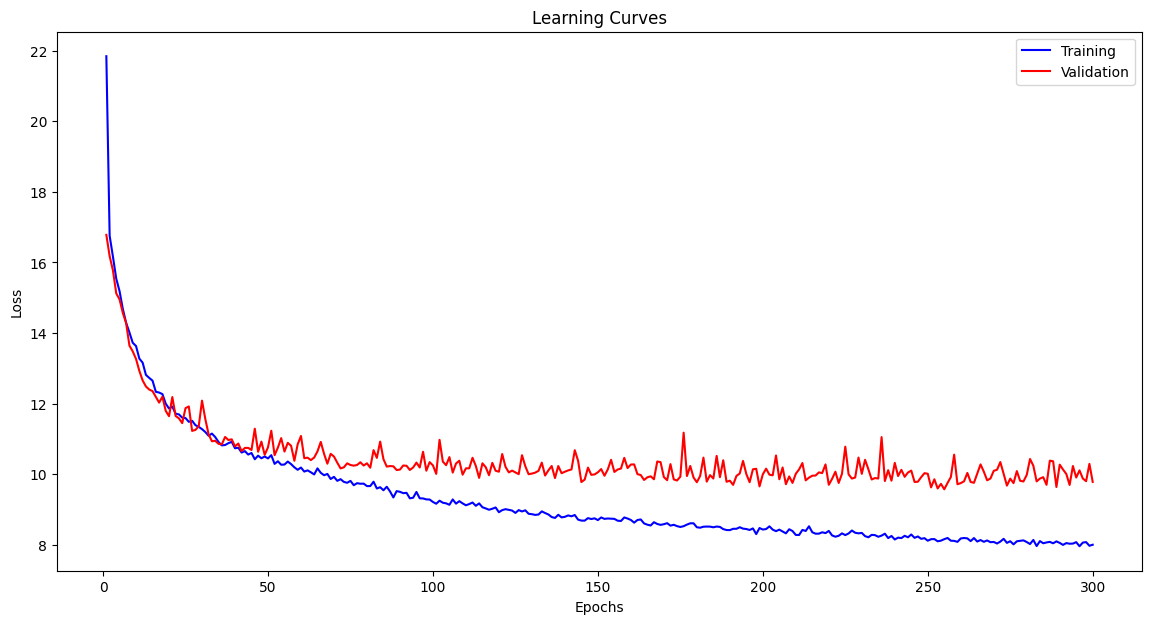

In [85]:
plt.figure(figsize=(14,7))
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training')
plt.plot(range(1, len(train_loss) + 1), val_loss, 'r', label='Validation')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [86]:
results_df

,Algorithm,MAE,Std Dev,Elapsed Time,N. input
0,SVM,11.60340,9.578544,88.282601,5000.0
1,RandomForest,12.31500,9.472749,71.241635,5000.0
2,AdaBoost,13.00740,9.780130,338.115361,5000.0
3,MLP,9.20422,12.197683,355.464216,17503.0


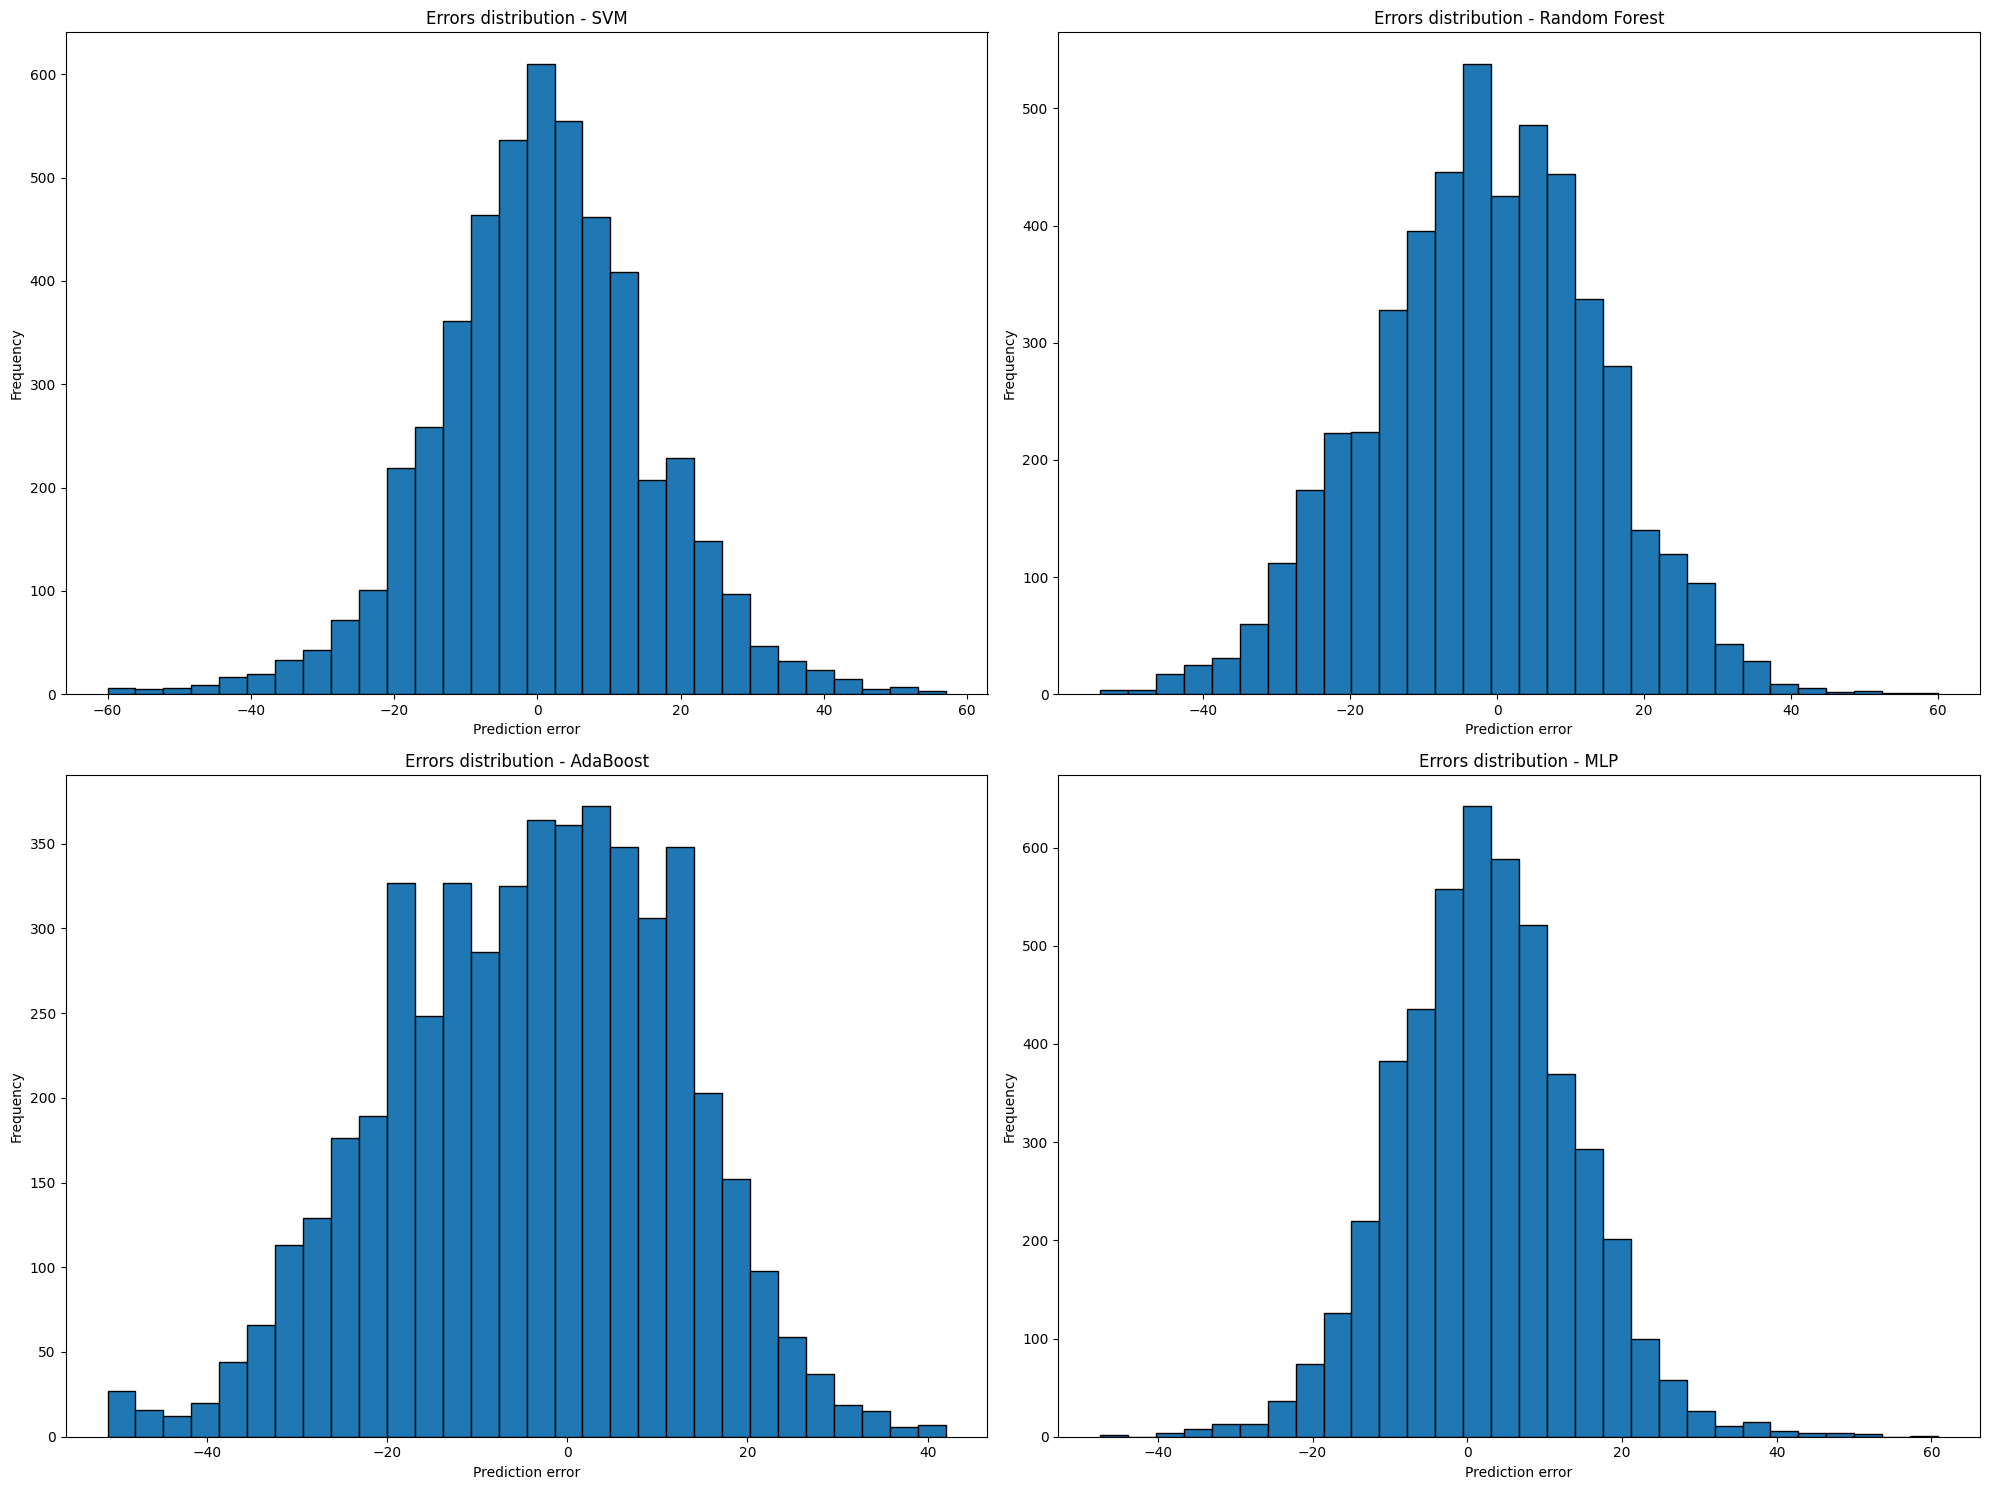

In [94]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

ax[0,0].hist(dff['age']-svm_pred.flatten(), bins=30, edgecolor='black')
ax[0,0].set_xlabel('Prediction error')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Errors distribution - SVM')

ax[0,1].hist(dff['age']-rf_pred.flatten(), bins=30, edgecolor='black')
ax[0,1].set_xlabel('Prediction error')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Errors distribution - Random Forest')

ax[1,0].hist(dff['age']-ab_pred.flatten(), bins=30, edgecolor='black')
ax[1,0].set_xlabel('Prediction error')
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_title('Errors distribution - AdaBoost')

ax[1,1].hist(dff_malati['age']-mlp_pred.flatten(), bins=30, edgecolor='black')
ax[1,1].set_xlabel('Prediction error')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_title('Errors distribution - MLP')

plt.tight_layout()  

plt.show()